In [625]:
%matplotlib inline

In [626]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.animation import FuncAnimation 
import matplotlib.animation as animation

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
#mpl.rc('figure',figsize=[4,3])
mpl.rc('figure',figsize=[3,3]) # figure size in inch
mpl.rc('figure',dpi=200) # inline dpi (=display size in browser)
mpl.rc('font',size=6.0)
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rc('lines',linewidth=0.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=0.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=0.3,linestyle=':')
mpl.rc('legend',fontsize='medium',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)
import numpy as np

In [627]:
from numpy.linalg import inv
from scipy import interpolate

In [628]:
def generate_mesh(L, N, V=0):
    nodes = np.zeros((N*N,2))
    tris = np.array([])
    h = L/(N-1)
    coord = np.linspace(0, L, N)
    #Choose variant and generate nodal coordinates
    if V==0:
        for i in range(N):
            nodes[N*i:N*(i+1), 0] = coord
            nodes[N*i:N*(i+1), 1] = coord[i]
    elif V==1:
        for i in range(N):        
            nodes[N*i:N*(i+1), 0] = np.linspace(0, L-i*h/2, N)
            nodes[N*i:N*(i+1), 1] = coord[i]
    elif V==2:
        for i in range(N):        
            nodes[N*i:N*(i+1), 1] = coord[i]
            nodes[N*i:N*(i+1), 0] = coord*(coord*coord[i]/(2*L**2)-coord[i]/(2*L)+1)
    elif V==3:
        angle = np.linspace(0, np.pi/4, N)
        radius = np.linspace(2*L, L, N)
        for i in range(N):        
            nodes[N*i:N*(i+1), 0] = 2*L-radius*np.cos(angle[i])
            nodes[N*i:N*(i+1), 1] = radius*np.sin(angle[i])
    
    #Generate odered triangular elements
    for j in range(N*(N-1)):
        if j%N == 0:
            t = np.array([j, j+1, j+N])
            tris = np.append(tris, t)
        elif j%(N) == N-1:
            t = np.array([j, j+N, j+N-1])
            tris = np.append(tris, t)
        else:
            t = np.array([j, j+N, j+N-1])
            tris = np.append(tris, t)
            t = np.array([j, j+1, j+N])
            tris = np.append(tris, t)
    tris = tris.reshape(int(tris.shape[0]/3), 3)
    tris = tris.astype(int)
    return nodes, tris

coords, elems = generate_mesh(0.02, 10)

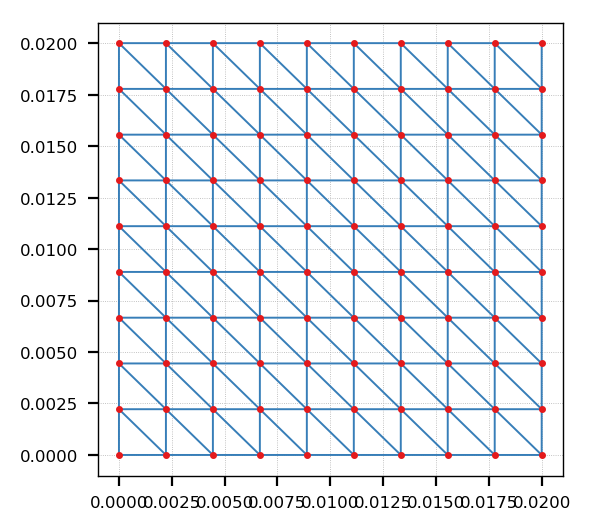

In [629]:
#Plot of the mesh
plt.figure()
plt.triplot(coords[:,0], coords[:,1], elems)
plt.plot(coords[:,0], coords[:,1], 'o', ms=1.5)
plt.show()


In [630]:
'''
Conductivity of elements
'''
def conductivity(elems, c, k0, V=None):
    k = k0*np.ones(elems.shape[0])
    if V=='4a':
        k1=c*k0
    elif V=='4b':
        k1=k0/c
    else:
        k1=k0
    k[43:48] = k1
    k[59:66] = k1
    k[76:83] = k1
    k[94:99] = k1
    return k

In [631]:
'''
Global stiff matrix computed with conversion to natural coordinates and shape functions evaluated at reference triangle

'''
def assemble_global(nodes, elems, k, hz):
    N = nodes.shape[0]
    H = np.zeros((N,N))
    for i in range(elems.shape[0]):
        #Element stiffness matrix
        n1 = nodes[elems[i, 0]]
        n2 = nodes[elems[i, 1]]
        n3 = nodes[elems[i, 2]]
        J = np.array([[n2[0]-n1[0], n2[1]-n1[1]],[n3[0]-n1[0], n3[1]-n1[1]]])
        Ji = inv(J)
        b1 = Ji@np.array([-1,-1])
        b2 = Ji@np.array([1,0])  
        b3 = Ji@np.array([0,1])  
        H_e = k[i]*hz/2*np.linalg.det(J)*np.array([[b1@b1.T, b1@b2.T, b1@b3.T],
                                                [b2@b1.T, b2@b2.T, b2@b3.T],[b3@b1.T, b3@b2.T, b3@b3.T]])
        #Global stiffness matrix 
        for l in range(3):
            for j in range(3):
                H[elems[i, l],elems[i, j]] += H_e[l,j]
    return H

In [632]:
'''
Alternative computation of global stiff matrix according, without the use of natural coordinates, 
according to the book p.125
'''
def assemble_global_alt(nodes, elems, k, hz):
    N = nodes.shape[0]
    H = np.zeros((N,N))
    for i in range(elems.shape[0]):
        #Element stiffness matrix
        n1 = nodes[elems[i, 0]]
        n2 = nodes[elems[i, 1]]
        n3 = nodes[elems[i, 2]]
        b1 = n2[1] - n3[1]
        b2 = n3[1] - n1[1]
        b3 = n1[1] - n2[1]
        c1 = n3[0] - n2[0]
        c2 = n1[0] - n3[0]
        c3 = n2[0] - n1[0]
        b = np.array([b1,b2,b3])
        c = np.array([c1,c2,c3])
        D = 0.5*(n1[0]*b1+n2[0]*b2+n3[0]*b3)
        H_e = k[i]/(4*D)*(np.outer(b,b)+np.outer(c,c))*hz
        #Global stiffness matrix 
        for l in range(3):
            for j in range(3):
                H[elems[i, l],elems[i, j]] += H_e[l,j]
    return H

In [633]:
'''
Solving the system
'''
#Variables
hz = 0.001
q = 1.5e+6
L = 0.02
k0 = 314
c = 30
Q = q*hz*L
k = conductivity(elems, c, k0)

#Assemble global matrix
H1 = assemble_global(coords, elems, k, hz)
#H1 = assemble_global_alt(coords, elems, k, hz)

#Get submatrices
H2 = H1[0:90,0:90]
H3 = H1[0:90,90:100]

#Forcing vector
P1 = np.zeros(90)
#Apply flux Neumann BCs
P1[0] = Q/18
P1[1:9] = Q/9
P1[9] = Q/18
print (P1.sum()/0.001/0.02) #check if total flux is correct

#Apply temperature Dirichlet BCs
Tn = 293*np.ones(10)

#RHS of the reduced system
RHS = P1-H3@Tn

#Solve for temparature
Tu = np.linalg.solve(H2,RHS)
T = np.append(Tu, Tn)
T1 = T.reshape(10,10)
print (T)

#Solve for missing Ps
P = H1@T
print (P)

1500000.0
[388.54140127 388.54140127 388.54140127 388.54140127 388.54140127
 388.54140127 388.54140127 388.54140127 388.54140127 388.54140127
 377.92569002 377.92569002 377.92569002 377.92569002 377.92569002
 377.92569002 377.92569002 377.92569002 377.92569002 377.92569002
 367.30997877 367.30997877 367.30997877 367.30997877 367.30997877
 367.30997877 367.30997877 367.30997877 367.30997877 367.30997877
 356.69426752 356.69426752 356.69426752 356.69426752 356.69426752
 356.69426752 356.69426752 356.69426752 356.69426752 356.69426752
 346.07855626 346.07855626 346.07855626 346.07855626 346.07855626
 346.07855626 346.07855626 346.07855626 346.07855626 346.07855626
 335.46284501 335.46284501 335.46284501 335.46284501 335.46284501
 335.46284501 335.46284501 335.46284501 335.46284501 335.46284501
 324.84713376 324.84713376 324.84713376 324.84713376 324.84713376
 324.84713376 324.84713376 324.84713376 324.84713376 324.84713376
 314.23142251 314.23142251 314.23142251 314.23142251 314.23142251


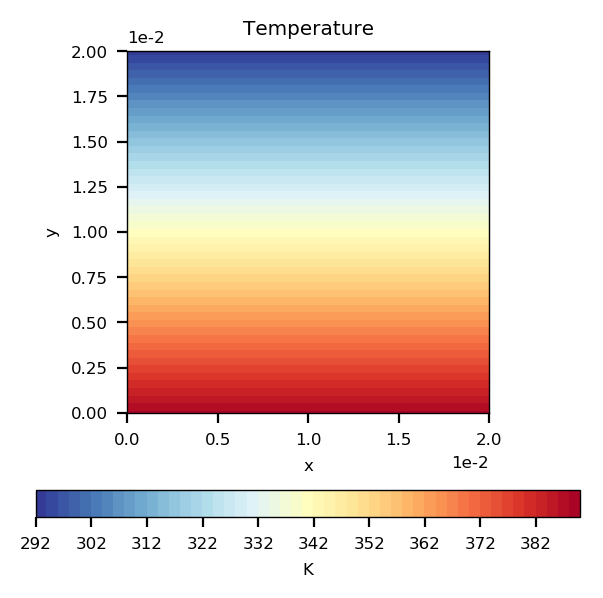

In [634]:
'''
Plotting temp - so far only for the square mesh
'''
X = coords[:10,0]
Y = coords[::10,1]
#Z = interpolate.interp2d(X, Y, T) # bilinear interpolation of the result
Xn = np.linspace(0, 0.02, 100)
Yn = np.linspace(0, 0.02, 100)
fig,ax=plt.subplots(1,1,)
#plt.triplot(coords[:,0], coords[:,1], elems)
#plt.plot(coords[:,0], coords[:,1], 'o')
#cp = ax.contour(Xn, Yn, Z(Xn,Yn), 100, cmap='RdYlBu_r')
cp = ax.contourf(X, Y, T1, 50, cmap='RdYlBu_r')
ax.set_title('Temperature')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('scaled')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,-2))

fig.colorbar(cp, label='K' ,orientation='horizontal')
plt.tight_layout()
plt.show()

In [635]:
'''
Compute temp gradient and flux at elements as well as the centroids of the elements for plotting
'''
def deriv_results(nodes, elems, T, k):
    N = nodes.shape[0]
    grad = np.zeros((elems.shape[0],2))
    flux = np.zeros((elems.shape[0],2))
    cents = np.zeros((elems.shape[0],2))
    for i in range(elems.shape[0]):
        n1 = nodes[elems[i, 0]]
        n2 = nodes[elems[i, 1]]
        n3 = nodes[elems[i, 2]]
        b1 = n2[1] - n3[1]
        b2 = n3[1] - n1[1]
        b3 = n1[1] - n2[1]
        c1 = n3[0] - n2[0]
        c2 = n1[0] - n3[0]
        c3 = n2[0] - n1[0]
        D = 0.5*(n1[0]*b1+n2[0]*b2+n3[0]*b3)
        cents[i,:] = np.array([(n1[0]+n2[0]+n3[0])/3,(n1[1]+n2[1]+n3[1])/3])
        bc = np.array([[b1,b2,b3],[c1,c2,c3]])
        Te = np.array([T[elems[i,0]],T[elems[i,1]],T[elems[i,2]]])
        grad[i,:] = 1/(2*D)*bc@Te.T
        flux[i, :] = -k[i]*grad[i,:]
    return grad, flux, cents

grad_T, q_tot, centroids = deriv_results(coords, elems, T, k)
#print (grad_T)
##print (centroids)

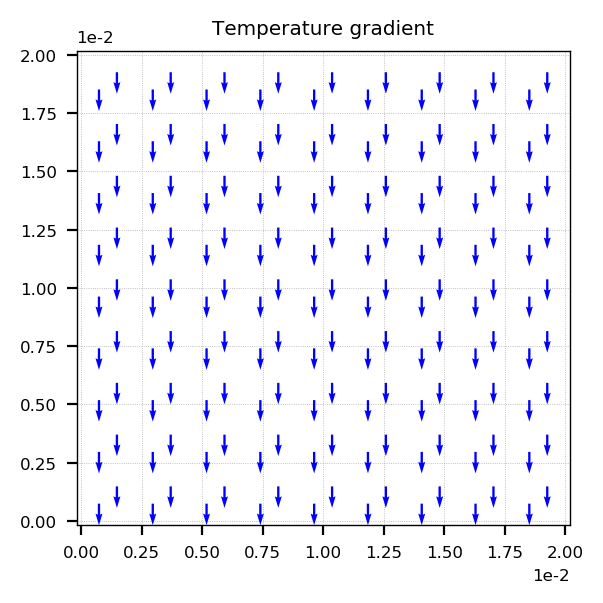

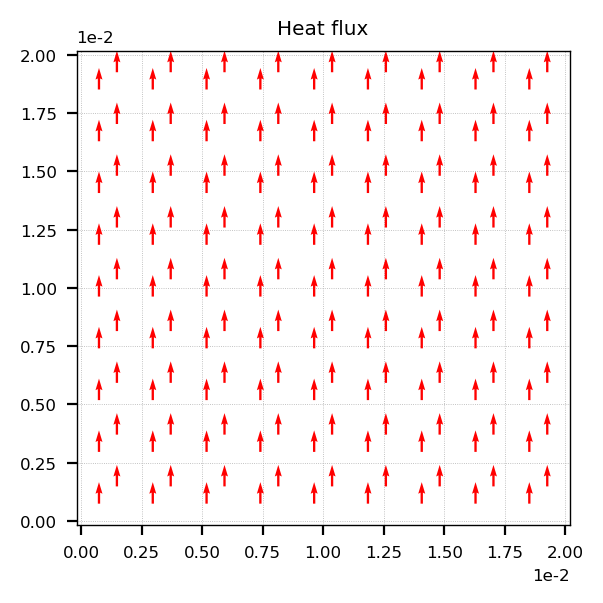

In [636]:
'''
Plot vector fields
'''
#Temp gradtient
X = centroids[:,0]
Y = centroids[:,1]
U = grad_T[:,0]
V = grad_T[:,1]
plt.quiver(X, Y, U, V, color='b')
#plt.triplot(coords[:,0], coords[:,1], elems)
plt.title('Temperature gradient')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,-2))
plt.tight_layout()
plt.show()

#Flux
Uf = q_tot[:,0]
Vf = q_tot[:,1]
plt.quiver(X, Y, Uf, Vf, color='r')
plt.title('Heat flux')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,-2))
plt.tight_layout()
plt.show()